# Performance Evaluation 



### Evaluation Methodology
Model execution produces a 1-km grid SWE estimates across the study region, where the evaluation methodology compares the modeled SWE from the testing dataset to the NASA ASO observations.
<img align = 'right' src="./Images/RMSE_R2.jpg" alt = 'image' width = '200'/>
As a submission to the USBR Snowcast Showdown, we use standard evaluation criteria of root-mean-squared-error (RMSE) and coefficient of determination (R<sup>2</sup>) of the predictions to determine model accuracy and efficiency across the domain, as these metrics framed the evaluation criteria for the modeling competition. 
where $\hat{y_i}$ denotes the predicted value for a sample $i$, $y_i$ the observed value, $\bar{y}$ the average observed value, and n the total number of samples. 

The coefficient of determination (R<sup>2</sup>) is a unitless measurement of the proportion of explained variance of the target variable by the model.
A maximum R<sup>2</sup> score of 1.0 indicates the predictor variables explain 100 percent of the variation in the target. 
In general, greater R<sup>2</sup> and lower RMSE represent better model predictive performance. 


## Preliminary Evaluation of the Model
Regional model evaluation is on the 25% testing data, where the known previous SWE values from NASA ASO flights support the previous SWE feature during model inference.
The model demonstrates high spatial extrapolation of point observations (selected SNOTEL) to regional 1-km grid prediction skill across all regions with R<sup>2</sup> values approaching 0.85, low regional RMSE values (4.4-in).

### Model Training/Testing influences and Bias on Model Performance.

The model training/testing partitioning methodology has a strong influence on model performance and the goal of model evaluation.
The objective of the modeling effort was to examine the spatial extrapolation capacity of the model from selected monitoring stations to the overall region, best suited to a 75/25% training/testing split, respectively.
While it is critical to address the strong serial correlation in SWE accumulation and melt throughout the season, the high correlation between weeks has the potential to inflate model skill when using a 75/25% training/testing split due to the previous SWE feature being known.
An assessment of the operational capacity of the model is different than assessing the ability to extrapolate regional SWE from in-situ monitoring stations.
For example, the operational capacity of the model should begin at the beginning of the water year (WY week 1) with a previous SWE value of 0-in for each 1-km grid.
Model evaluation could then assess the forecasting skill on a hold-out dataset of an entire year in which known neighboring values do not control predictions, but rather driving to-date predictions from the predicted previous SWE values. 
Due to the high model performance, future work will target the assessment of model skill with an operational motivation

In [57]:
#Load packages
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import h5py
import tables
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from pickle import dump
import pickle 



In [58]:
### define new regions
Region_list = [
               'N_Co_Rockies',
              ]

#Load the predictions/observations for the testing dataframe
### Load H5 train files into dictionary
RegionTrain= {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf('Provided_Data/Final_Training_DF.h5', region)

pred_obs = {}
pred_obs['N_Co_Rockies'] = pd.read_hdf('Model/Model_Training/Model_Validation/Region_Predictions.h5', key = 'N_Co_Rockies')

y_pred = pred_obs['N_Co_Rockies']['y_pred']
y_test = pred_obs['N_Co_Rockies']['y_test']



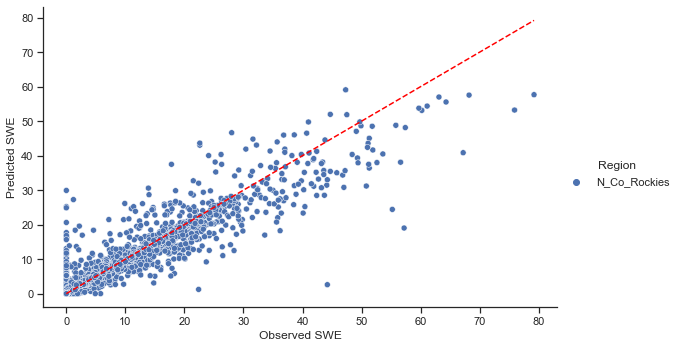

 R2 is  0.8518941686314744
 RMSE is  4.339649953250585


In [59]:
#Plot the results in a parity plot
sns.set(style='ticks')
SWEmax = max(y_test)

sns.relplot(data=pred_obs['N_Co_Rockies'], x='y_test', y='y_pred', hue='Region', hue_order=Region_list, aspect=1.61)
plt.plot([0,SWEmax], [0,SWEmax], color = 'red', linestyle = '--')
plt.xlabel('Observed SWE')
plt.ylabel('Predicted SWE')
plt.show()

#Run model evaluate functions
r2_test = sklearn.metrics.r2_score(y_test, y_pred)
rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
print(' R2 is ', r2_test)
print(' RMSE is ', rmse_test)

Model performance is quite high.

## More in-depth model evaluation.
We want to evaluate the model over the course of seasonal snow accumulation and melt, at differnt elevation bands, and spatially.


In [60]:
def Eval_DF(RegionTrain, Region, Predictions):
    #get the testing split
    y = RegionTrain[Region]['SWE']
    X = RegionTrain[Region]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
    
    #Combine predictions with testing testing dependent DF,     
    X_test['y_pred'] = Predictions[Region]['y_pred']
    X_test['error'] = X_test['SWE'] - X_test['y_pred']
    
    #select key topographical and temporal features of interest for model evaluation
    cols = ['Date', 'Long', 'Lat', 'elevation_m', 'prev_SWE', 'WYWeek', 'northness', 'SWE','y_pred', 'error']
    X_test = X_test[cols]
    
    return X_test

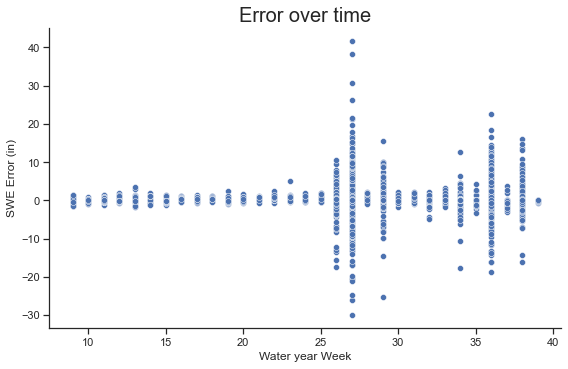

In [61]:
#Process the data into a useful dataframe for analysis
x = Eval_DF(RegionTrain, 'N_Co_Rockies', pred_obs)


#Plot the temporal error
sns.set(style='ticks')
sns.relplot(data=x, x='WYWeek', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Water year Week')
plt.ylabel('SWE Error (in)')
plt.title("Error over time", fontsize = 20)
plt.show()

### A substantial amount of model error can  be attributed to time.
It appears the model exihibits limitations in predicting SWE during the melt phase.

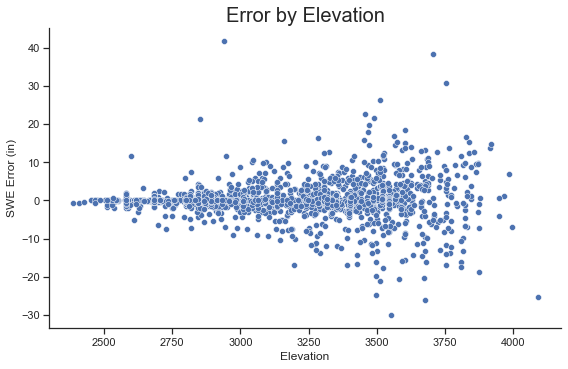

In [62]:
#Plot the error by elevation
sns.set(style='ticks')
sns.relplot(data=x, x='elevation_m', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Elevation')
plt.ylabel('SWE Error (in)')
plt.title("Error by Elevation", fontsize = 20)
plt.show()

### Model error increases with elevation


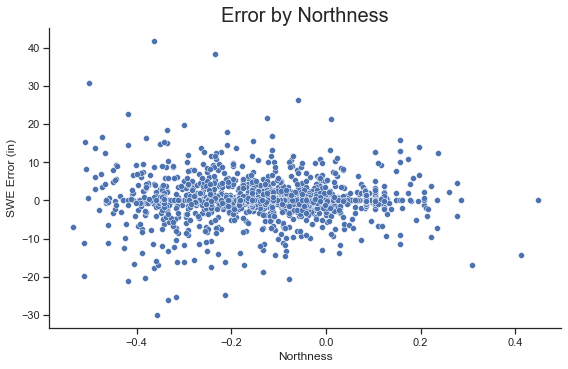

In [63]:
#Plot the error by slope/angle = northness
sns.set(style='ticks')
sns.relplot(data=x, x='northness', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Northness')
plt.ylabel('SWE Error (in)')
plt.title("Error by Northness", fontsize = 20)
plt.show()

### There appears to be no significant model error attributed to northness

Lets look at the model predictions spatially, any patterns we can observe?

In [64]:
#load regionalized geospatial data
RegionTrain = open("Provided_Data/RegionTrain.pkl", "rb")
RegionSnotel = open("Provided_Data/RegionSnotel.pkl", "rb")

RegionTrain = pickle.load(RegionTrain)
RegionSnotel = pickle.load(RegionSnotel)

#Create Geospatial prediction point DF
Pred_Geo = RegionTrain['N_Co_Rockies'].copy()
Pred_Geo = Pred_Geo.reset_index().drop_duplicates(subset='cell_id', keep='last').set_index('cell_id').sort_index()
cols = ['Long','Lat','elevation_m','slope_deg','aspect']
Pred_Geo= Pred_Geo[cols].reset_index()
Pred_Geo

,cell_id,Long,Lat,elevation_m,slope_deg,aspect
0,0027a004-df14-4d66-a3e4-e987336b8814,-106.802801,38.883190,3233.50,17.50,119.25
1,0036f966-3430-45f3-b6a2-803e678a1c2b,-106.955515,39.029885,3608.75,16.75,81.50
2,003cec54-9e23-4c5b-8577-fc968ba1e9d2,-105.949401,39.537461,3275.00,16.25,186.75
3,007a29fe-066d-4bb9-b349-35c24b57ad87,-107.251959,39.015927,3269.50,19.50,201.25
4,008bbce5-1193-41c0-bda1-7ae421f700b8,-106.793818,38.743197,2901.50,14.75,119.25
...,...,...,...,...,...,...
1752,ff38e604-71fc-4be8-8352-59c4ecbf8943,-106.712969,38.764214,3168.25,15.75,169.00
1753,ff49d2dc-04bc-4e3c-b911-760fc14966a6,-106.748902,38.687124,2729.75,11.00,166.75
1754,ff8508d6-2a06-485f-a896-7c67b9fd79e8,-107.054329,39.036863,3277.75,17.50,180.50
1755,ffae0d8b-736b-4a85-a99c-ff47c07ca7dd,-106.766868,39.008947,3659.00,12.50,145.00


### Use Folium and Geopandas to spatially visualize the predictions

In [65]:
import geopandas as gpd
import folium
from folium import features
from folium.plugins import StripePattern
import branca.colormap as cm
import vincent
from vincent import AxisProperties, PropertySet, ValueRef, Axis
import hvplot.pandas
import holoviews as hv
from holoviews import dim, opts, streams
from bokeh.models import HoverTool
import hydroeval as he
import json
import warnings; warnings.filterwarnings("ignore")



#Map locations and scoring of sites
#def Map_Plot_Eval(self, freq, df, size):
def Map_Plot_Eval(GeoDF, Snotel, obs, err, pred, yaxis):   

    print('Plotting monitoring station locations')
    cols =  ['cell_id', 'Lat', 'Long', 'geometry']

    df_map = GeoDF[cols].copy()

    #Get Centroid of watershed
    centeroid = df_map.dissolve().centroid

    # Create a Map instance
    m = folium.Map(location=[centeroid.y[0], centeroid.x[0]], tiles = 'Stamen Terrain', zoom_start=8, 
                   control_scale=True)
    #add legend to map
    colormap = cm.StepColormap(colors = ['darkred', 'r', 'orange', 'g'], vmin = 0, vmax = 1, index = [0,0.4,0.6,0.85,1])
    colormap.caption = 'Model Performance (KGE)'
    m.add_child(colormap)

    ax = AxisProperties(
    labels=PropertySet(
        angle=ValueRef(value=300),
        align=ValueRef(value='right')
            )
        )

    for i in obs.columns:


        #get site information
        site = i
        Obs_site = 'Observations'#_' + site
        Pred_site = 'Predictions'#_' + site
        Err_site = 'Errors'#_' + site


        #get modeled, observed, and error information for each site
        df = pd.DataFrame(obs[site])
        df = df.rename(columns = {site: Obs_site})
        df[Pred_site] = pd.DataFrame(pred[site])
        df[Err_site] = pd.DataFrame(err[site])

        #set the color of marker by model performance
        kge, r, alpha, beta = he.evaluator(he.kge, df[Pred_site].astype('float32'), df[Obs_site].astype('float32'))

        if kge[0] > 0.85:
            color = 'green'

        elif kge[0] > 0.6:
            color = 'orange'

        elif kge[0] > 0.40:
            color = 'red'

        else:
            color = 'darkred'

        title_size = 14

        #create graph and convert to json
        graph = vincent.Scatter(df, height=300, width=500)
        graph.axis_titles(x='Datetime', y=yaxis)
        graph.legend(title= 'Legend')
        graph.colors(brew='Set1')
        graph.x_axis_properties(title_size=title_size, title_offset=35,
                      label_angle=300, label_align='right', color=None)
        graph.y_axis_properties(title_size=title_size, title_offset=-30,
                      label_angle=None, label_align='right', color=None)

        data = json.loads(graph.to_json())

        #Add marker with point to map, https://fontawesome.com/v4/cheatsheet  - needs to be v4.6 or less
        lat_long = df_map[df_map['cell_id'] == i]
        lat = lat_long['Lat'].values[0]
        long = lat_long['Long'].values[0]

        mk = features.Marker([lat, long], icon=folium.Icon(color=color, icon = ' fa-ge', prefix = 'fa'))
        p = folium.Popup()
        v = features.Vega(data, width="100%", height="100%")

        mk.add_child(p)
        p.add_child(v)
        m.add_child(mk)
        
        
    # add SNOTEL marker one by one on the map
    for i in range(0,len(Snotel)):
        

        folium.Marker(
          location=[Snotel.iloc[i]['Lat'], Snotel.iloc[i]['Long']],
            icon=folium.Icon(color='blue', icon = 'fa-area-chart', prefix = 'fa'),
            tooltip = str(Snotel.iloc[i]['location']) + ": " + str(Snotel.iloc[i]['station_id']),
          popup= str(Snotel.iloc[i]['location']) + ": " + str(Snotel.iloc[i]['elevation_m']) + "m",
       ).add_to(m)

    display(m)
    
    
def df_transpose(df, obs):
    #get index
    date_idx = df.index.unique()
    #get columns names, aka sites
    sites = df['cell_id'].values
    #make dataframe
    DF =pd.DataFrame(index = date_idx)
    for site in sites:
        s = pd.DataFrame(df[df['cell_id'] == site][obs])
        DF = DF.join(s)
        DF = DF.rename(columns ={obs: site})
    DF = DF.loc[:,~DF.columns.duplicated()].copy()
    return DF 

In [66]:
#need to put the predictions, obs, error in s time series format
x.index = x.index.set_names(['cell_id'])

#predictions
x_pred = x.copy()
cols = ['Date','y_pred']
x_pred = x_pred[cols].reset_index().set_index('Date').sort_index()
x_pred = df_transpose(x_pred, 'y_pred')

#observations
x_obs = x.copy()
cols = ['Date','SWE']
x_obs = x_obs[cols].reset_index().set_index('Date').sort_index()
x_obs = df_transpose(x_obs, 'SWE')

#error
x_err = x.copy()
cols = ['Date','error']
x_err = x_err[cols].reset_index().set_index('Date').sort_index()
x_err = df_transpose(x_err, 'error')

In [67]:
#Get SNOTEL sites used as features
#load RFE optimized features
Region_optfeatures= pickle.load(open("Model/Model_Features/Optimal_Features.pkl", "rb"))
Sites = [match for match in Region_optfeatures['N_Co_Rockies'] if 'Delta_SWE'  in match]
for i in np.arange(0, len(Sites),1):
    Sites[i] = Sites[i].replace('Delta_SWE_', '')   


    
#Convert the Prediction Geospatial dataframe into a geopandas dataframe
GeoDF = gpd.GeoDataFrame(Pred_Geo, geometry = gpd.points_from_xy(Pred_Geo.Long, Pred_Geo.Lat))
SNOTEL_Geo = gpd.GeoDataFrame(RegionSnotel['N_Co_Rockies'], geometry = gpd.points_from_xy(RegionSnotel['N_Co_Rockies'].Long, RegionSnotel['N_Co_Rockies'].Lat))

#Select sites used for prediction
SNOTEL_Geo = SNOTEL_Geo.set_index('station_id').T[Sites].T.reset_index()

In [69]:
#Run folium plotting function
Map_Plot_Eval(GeoDF,SNOTEL_Geo, x_obs, x_err, x_pred, 'SWE (in)')

<img align = 'center' src="./Images/Spatial_Analysis_1.JPG" alt = 'image' width = '1000'/>

### There are a lot of spatial errors, lets see if we can figure out why

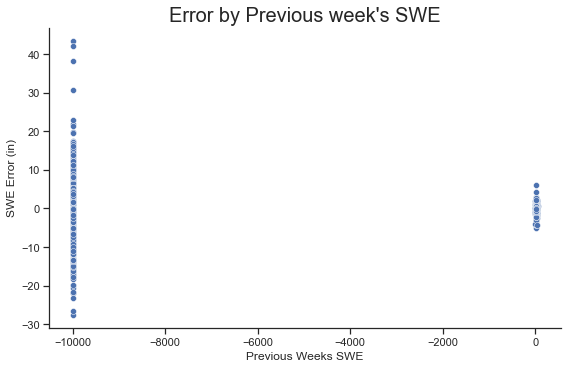

In [47]:
#Plot the error by the previous weeks SWE
sns.set(style='ticks')
sns.relplot(data=x, x='prev_SWE', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Previous Weeks SWE')
plt.ylabel('SWE Error (in)')
plt.title("Error by Previous week's SWE", fontsize = 20)
plt.show()

### The primary cause of model error is not having a Previous SWE value!
Wow, this plot clearly identifies where the model errors can be attributed to.

## More In-Depth Model Evaluation
### Missing Previous week's values have a substantial impact on model performance.
Lets look at the predictions that have a previous week's value and evaluate how the model performs.

The model evaluation indicate a strong correlation between observed and predicted SWE, with few outliers existing in the model prediction.
Selecting predictions that have a previous week's value result in substantially greater R<sup>2</sup> values approaching 1 (0.99) for the Upper Colorado River Basin region, indicating the predictor terms capture nearly all of the variance in SWE.
Complementing the high R<sup>2</sup> values, the RMSE drops over 3" to 0.86". 

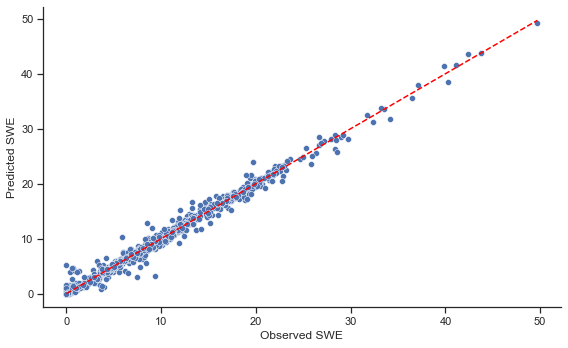

 R2 is  0.9869439223442905
 RMSE is  0.8627493797382823


In [48]:
#select for locations where there is a previous week's observation
x_prev = x[x['prev_SWE']>=0]

SWEmax = max(x_prev['SWE'])

sns.relplot(data=x_prev, x='SWE', y='y_pred', hue_order=Region_list, aspect=1.61)
plt.plot([0,SWEmax], [0,SWEmax], color = 'red', linestyle = '--')
plt.xlabel('Observed SWE')
plt.ylabel('Predicted SWE')
plt.show()

#Run model evaluate functions
r2_test = sklearn.metrics.r2_score(x_prev['SWE'], x_prev['y_pred'])
rmse_test = sklearn.metrics.mean_squared_error(x_prev['SWE'], x_prev['y_pred'], squared = False)
print(' R2 is ', r2_test)
print(' RMSE is ', rmse_test)

## Greatly improved modeling performorance!!



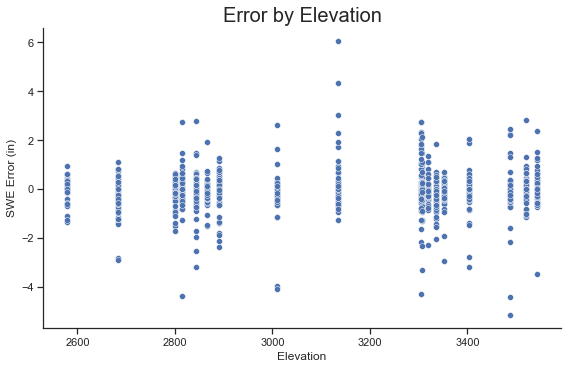

In [49]:
#Plot the error by elevation
sns.set(style='ticks')
sns.relplot(data=x_prev, x='elevation_m', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Elevation')
plt.ylabel('SWE Error (in)')
plt.title("Error by Elevation", fontsize = 20)
plt.show()

### There is a small bias in error, increasing at higher elevations

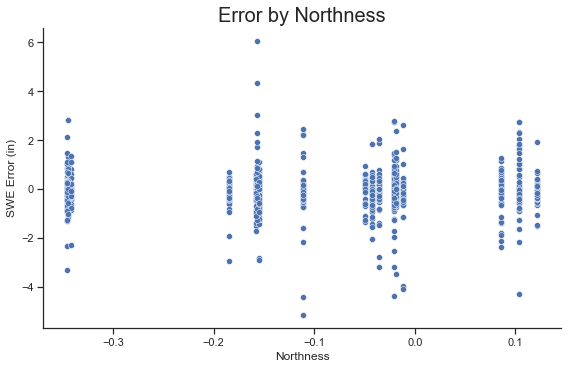

In [50]:
#Plot the error by slope/angle = northness
sns.set(style='ticks')
sns.relplot(data=x_prev, x='northness', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Northness')
plt.ylabel('SWE Error (in)')
plt.title("Error by Northness", fontsize = 20)
plt.show()

### There is no apparent bias by northness.

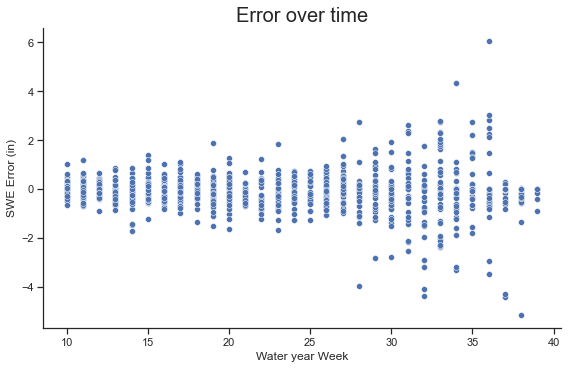

In [51]:
#Plot the temporal error
sns.set(style='ticks')
sns.relplot(data=x_prev, x='WYWeek', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Water year Week')
plt.ylabel('SWE Error (in)')
plt.title("Error over time", fontsize = 20)
plt.show()

### The majority of model error can clearly be attributed to time.
It appears the model exihibits limitations in predicting SWE during the melt phase.

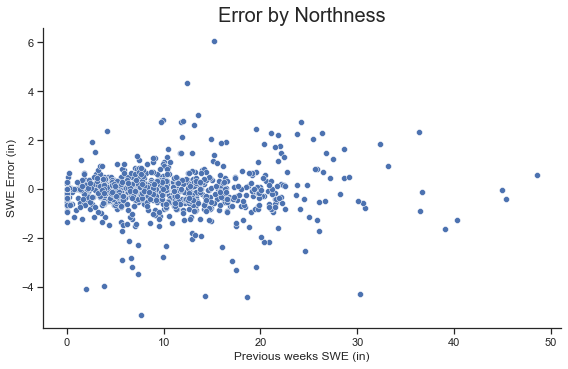

In [52]:
#Plot the error by slope/angle = northness
sns.set(style='ticks')
sns.relplot(data=x_prev, x='prev_SWE', y='error', hue_order=Region_list, aspect=1.61)
plt.xlabel('Previous weeks SWE (in)')
plt.ylabel('SWE Error (in)')
plt.title("Error by Northness", fontsize = 20)
plt.show()

## Lets look at the errors spatially again

In [53]:
#need to put the predictions, obs, error in s time series format
x_prev.index = x_prev.index.set_names(['cell_id'])

#predictions
x_pred = x_prev.copy()
cols = ['Date','y_pred']
x_pred = x_pred[cols].reset_index().set_index('Date').sort_index()
x_pred = df_transpose(x_pred, 'y_pred')

#observations
x_obs = x_prev.copy()
cols = ['Date','SWE']
x_obs = x_obs[cols].reset_index().set_index('Date').sort_index()
x_obs = df_transpose(x_obs, 'SWE')

#error
x_err = x_prev.copy()
cols = ['Date','error']
x_err = x_err[cols].reset_index().set_index('Date').sort_index()
x_err = df_transpose(x_err, 'error')

In [56]:
#Run folium plotting function
Map_Plot_Eval(GeoDF,SNOTEL_Geo, x_obs, x_err, x_pred, 'SWE (in)')

<img align = 'center' src="./Images/Spatial_Analysis.JPG" alt = 'image' width = '1000'/>

<img align = 'center' src="./Images/Spatial_Analysis2.JPG" alt = 'image' width = '1000'/>

<img align = 'center' src="./Images/Spatial_Analysis3.JPG" alt = 'image' width = '1000'/>

### Much better performance
We can now see that the model can spatially extrapolate and that there is a significant need for improved temporal resolution data.
Future work can investigate different data processing methods to realize more previous SWE features.



## Model Training/Testing influence on Model Results.

The model training/testing partitioning methodology has a strong influence on model performance and the goal of model evaluation.
The objective of the modeling effort was to examine the spatial extrapolation capacity of the model from selected monitoring stations to the overall region, best suited to a 75/25% training/testing split, respectively.
While it is critical to address the strong serial correlation in SWE accumulation and melt throughout the season, the high correlation between weeks has the potential to inflate model skill when using a 75/25% training/testing split due to the previous SWE feature being known.
An assessment of the operational capacity of the model is different than assessing the ability to extrapolate regional SWE from in-situ monitoring stations.
For example, the operational capacity of the model should begin at the beginning of the water year (WY week 1) with a previous SWE value of 0-in for each 1-km grid.
Model evaluation could then assess the forecasting skill on a hold-out dataset of an entire year in which known neighboring values do not control predictions, but rather driving to-date predictions from the predicted previous SWE values. 
Due to the high model performance, future work will target the assessment of model skill with an operational motivation.


## Exploring the Prediction results

Effective modeling of elevation gradients leads to a realistic modeled SWE across heterogeneous terrain. 
For example, the  higher elevation bands display greater modeled SWE values compared to lower elevations associated, and the highest elevation bands display less SWE reflecting exposed terrain subject to wind transport and snow redistribution.
This is indicative that the model is robust to differing generalized topographical and geographical characteristics and is capable of capturing elevation gradients effectively.
While the model uses northness as a feature to represent the average slope and aspect of the 1-km grid, overlaying the predictions on complex topography indicates a need for high resolution prediction.
Examination of the 1-km resolution indicates it is too coarse to capture rapid topographical changes common to montane environments, but does indicate an increas in northness lead to an increase in SWE.

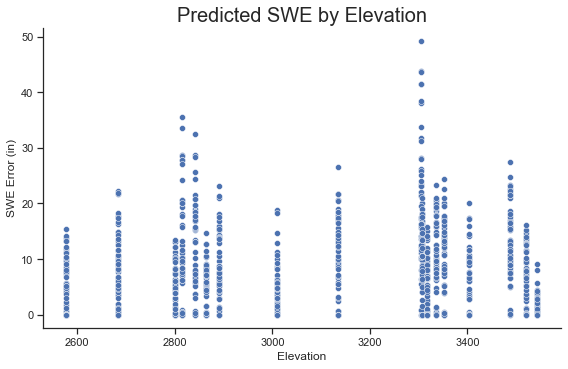

In [31]:
#Plot the SWE by elevation
sns.set(style='ticks')
sns.relplot(data=x_prev, x='elevation_m', y='y_pred', hue_order=Region_list, aspect=1.61)
plt.xlabel('Elevation')
plt.ylabel('SWE Error (in)')
plt.title("Predicted SWE by Elevation", fontsize = 20)
plt.show()

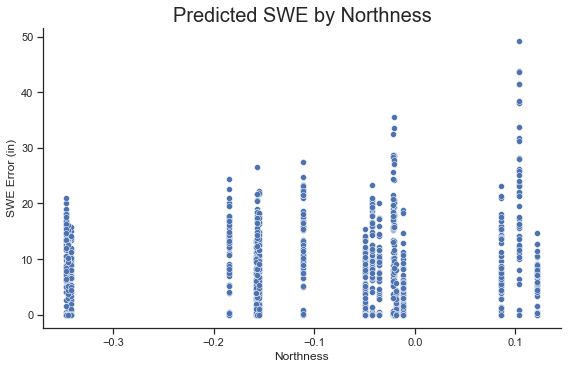

In [32]:
#Plot the SWE by northness
sns.set(style='ticks')
sns.relplot(data=x_prev, x='northness', y='y_pred', hue_order=Region_list, aspect=1.61)
plt.xlabel('Northness')
plt.ylabel('SWE Error (in)')
plt.title("Predicted SWE by Northness", fontsize = 20)
plt.show()



Next [Chapter](./workflow.ipynb).
